# AIoT Project 2023

In [1]:
import os

# basic data engineering
import pandas as pd
import numpy as np
import scipy

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import seaborn as sns

# db
import pymongo

# configs & other
import yaml
# from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time

# from psynlig import pca_explained_variance_bar

# utils processing
from utils import sliding_window_pd
from utils import apply_filter
from utils import filter_instances
from utils import flatten_instances_df
from utils import df_rebase
from utils import rename_df_column_values

# utils visualization
from utils_visual import pca_explained_variance_bar

%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'plot_instance_time_domain' from 'utils_visual' (/home/gpanaritis/Documents/GitHub/Handwriting-Sensor-Recognition/src/utils_visual.py)

## Load configuration

In [ ]:
config_path = "config.yml"

with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
client = pymongo.MongoClient(config["client"])

In [ ]:
db = client[config["db"]]
coll = db[config["col"]]

In [ ]:
found_keys = coll.distinct("label")
print("Existing DB keys:", found_keys)

Existing DB keys: ['α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ']


In [ ]:
data = list(coll.find({}, {'label': 1, 'data': 1, 'datetime': 1}))
df = pd.DataFrame(data)
print("Dataframe shape:", df.shape)

Dataframe shape: (320, 4)


## Barplot (Mean Length of data per Label)

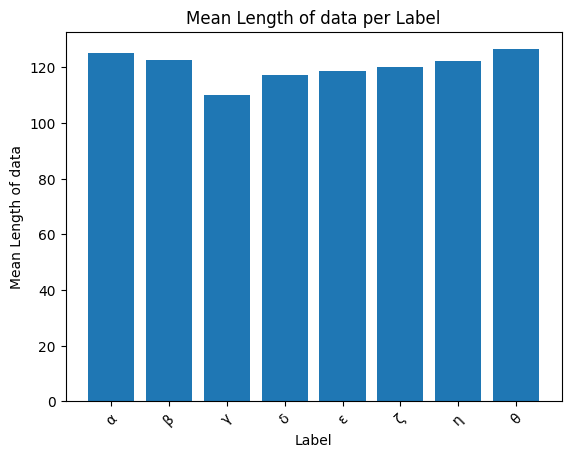

In [ ]:
# distinct labels
labels = df["label"].unique() # type: ignore
# get data length for each label
label_mean_lengths = df.groupby('label')['data'].apply(lambda x: x.apply(lambda arr: len(arr['acc_x'])).mean())

# Create a bar plot
plt.bar(label_mean_lengths.index, label_mean_lengths.values) # type: ignore

# Set labels and title
plt.xlabel('Label')
plt.ylabel("Mean Length of data")
plt.title("Mean Length of data per Label")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

## Windows

In [ ]:
sl  = config["sliding_window"]
w = []

for x in df["data"]:
    df_x = pd.DataFrame(x) # type: ignore
    windows = sliding_window_pd(df_x, ws= sl["ws"], overlap= sl["overlap"], w_type= sl["w_type"], w_center= sl["w_center"], print_stats= sl["print_stats"])
    w.append(pd.Series(windows))

df["windows"] = w

## Barlpot of the number of windows per label

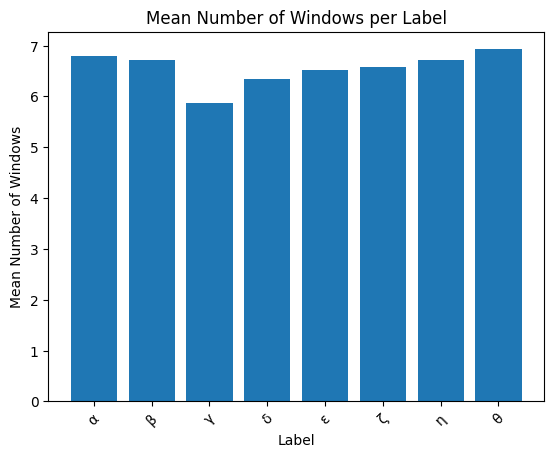

In [ ]:
# distinct labels
labels = df["label"].unique() # type: ignore
# get data length for each label
windows_mean_lengths = df.groupby('label')['windows'].apply(lambda x: x.apply(lambda arr: len(arr)).mean())

# Create a bar plot
plt.bar(windows_mean_lengths.index, windows_mean_lengths.values) # type: ignore

# Set labels and title
plt.xlabel('Label')
plt.ylabel("Mean Number of Windows")
plt.title("Mean Number of Windows per Label")

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()

## Apply filter

In [ ]:
# get list from df["windows"]
windows = df["windows"].tolist() # type: ignore
filtered_windows = filter_instances(windows, order= config["filter"]["order"], wn= config["filter"]["wn"], filter_type= config["filter"]["type"])

Number of filtered instances in the list: 320


## Transform the list of DataFrames to NumPy array

Transform the list of DataFrames to NumPy array that contains the windows: (instances, x, y)

In [ ]:
new_df = flatten_instances_df(filtered_windows)

## Flatten the 2D window instances

Flatten the X NumPy array that contains the 2D window instances

In [ ]:
X = np.array(new_df)

le = X[0][0].shape

# Make all instances the same length by filling with NaN
l = len(X[0])
for i,x in enumerate(X):
    for j,y in enumerate(x):
        if y is None:
            fill = np.empty(le)
            fill[:] = np.nan
            X[i][j] = fill

# flatten instances
X = np.array([np.array([x.flatten() for x in row]) for row in X])
        
# factorize labels
y = np.array(df["label"].tolist()) # type: ignore
y = pd.factorize(y)[0]

# print shapes
print(y.shape)
print(X.shape)

(320,)
(320, 8, 180)


## Train/Test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state= config["random_state"])

In [ ]:
print("X_train shape:" + str(X_train.shape)) #noqa
print("X_test shape:" + str(X_test.shape))

X_train shape:(256, 8, 180)
X_test shape:(64, 8, 180)


## Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
# Standard scaler for X
scaler = StandardScaler()

# MinMax scaler for X
scaler2 = MinMaxScaler()

# Reshape data to 2d array
train_data_scaled = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
test_data_scaled = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

# Fit on training set only.
scaler2.fit(train_data_scaled)

# Apply transform to both the training set and the test set.
train_data_scaled = scaler2.transform(train_data_scaled)
test_data_scaled = scaler2.transform(test_data_scaled)

# Fit on training set only.
scaler.fit(train_data_scaled)

# Apply transform to both the training set and the test set.
train_data_scaled = scaler.transform(train_data_scaled)
test_data_scaled = scaler.transform(test_data_scaled)

## Imputing NaN values

In [ ]:
from sklearn.impute import KNNImputer

# Custom callable for weights
def custom_weights(distances):
    # Calculate distance mod 6
    mod_distances = distances % (6)

    # Assign weight 1 / (distance ^ 2) to neighbors with distance mod 6 equal to 0, weight 0 to others
    weights = np.where(mod_distances == 0, 1 / (distances**2), 0)

    return weights

imp = KNNImputer(n_neighbors=100, weights=custom_weights)
train_data_scaled = imp.fit_transform(train_data_scaled)
test_data_scaled = imp.fit_transform(test_data_scaled)

## Transform to 2D again

In [ ]:
X_train_2d = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test_2d = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

## Dimensionality Reduction with PCA using the 1D (flattened) data

In [ ]:
from sklearn.decomposition import PCA

#### Set dicts (will help with the plot)

In [ ]:
colors = {0: "red", 1: "blue", 2: "green", 3: "yellow", 4: "orange", 5: "purple", 6: "pink", 7: "brown", 8: "black", 9: "gray"}
labels = {0: "α", 1: "β", 2: "γ", 3: "δ", 4: "ε", 5: "ζ", 6: "η", 7: "θ", 8: "ι", 9: "κ"}

#### Pca 1d

In [ ]:
# PCA with 1 component
pca = PCA(n_components=1)

transformed_x = pca.fit_transform(train_data_scaled)

#### Plot pca-1d

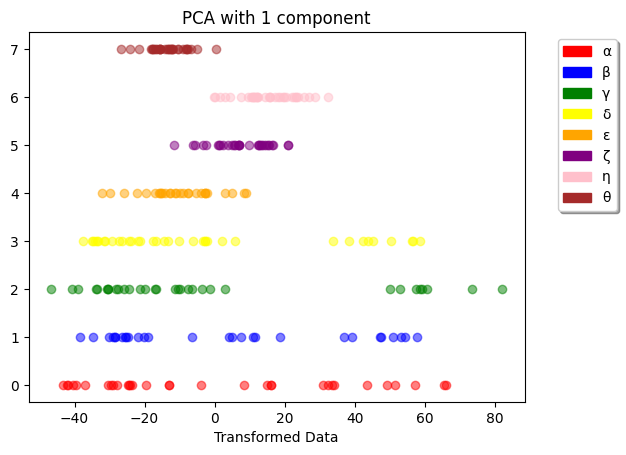

In [ ]:
# Transform data and plot
fig, ax = plt.subplots()

# Create empty lists to store legend handles and labels
legend_handles = []
legend_labels = []

# Iterate through the transformed data, organized by group
for i, x in enumerate(transformed_x):
    label = labels[y_train[i]]
    color = colors[y_train[i]]
    ax.scatter(x, y_train[i], alpha=0.5, label=label, color=color)

    # Append a patch with custom color to the legend_handles list
    if label not in legend_labels:
        legend_patch = mpatches.Patch(color=color, label=label)
        legend_handles.append(legend_patch)
        legend_labels.append(label)

# Sort the legend labels alphabetically
sorted_legend_labels = sorted(legend_labels)

# Create a new list of sorted legend handles corresponding to the sorted labels
sorted_legend_handles = [legend_handles[legend_labels.index(label)] for label in sorted_legend_labels]

# Add the custom legend using the created handles and labels
ax.legend(handles=sorted_legend_handles, labels=sorted_legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1, fancybox=True, shadow=True)

# Add x-axis and y-axis labels
ax.set_xlabel("Transformed Data")
ax.set_title("PCA with 1 component")

# Show plot
plt.show()

### PCA with 2 Components

In [ ]:
pca = PCA(n_components=2)
transformed_x = pca.fit_transform(train_data_scaled)

# fig, ax = plt.subplots()
# for i,x in enumerate(transformed_x):
#     ax.scatter(x[0], x[1], alpha=0.5, label="PCA", color=colors[y_train[i]])
# ax.set_xlabel("Transformed Data")
# ax.set_title("PCA with 2 components")
# ax.xaxis.grid(True)
# plt.show()

#### Plot the 2d pca

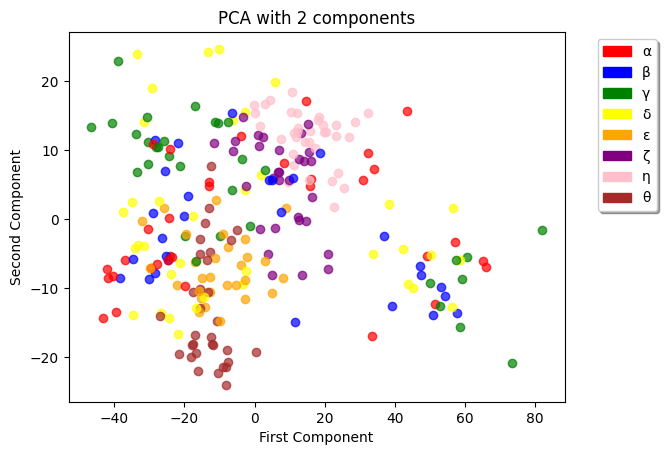

In [ ]:
fig, ax = plt.subplots()

# Create empty lists to store legend handles and labels
legend_handles = []
legend_labels = []

# Iterate through the transformed data, organized by group
for i, x in enumerate(transformed_x):
    label = labels[y_train[i]]
    color = colors[y_train[i]]
    ax.scatter(x[0], x[1], alpha=0.7, label=label, color=color)

    # Append a patch with custom color to the legend_handles list
    if label not in legend_labels:
        legend_patch = mpatches.Patch(color=color, label=label)
        legend_handles.append(legend_patch)
        legend_labels.append(label)

# Sort the legend labels alphabetically
sorted_legend_labels = sorted(legend_labels)

# Create a new list of sorted legend handles corresponding to the sorted labels
sorted_legend_handles = [legend_handles[legend_labels.index(label)] for label in sorted_legend_labels]

# Add the custom legend using the created handles and labels
ax.legend(handles=sorted_legend_handles, labels=sorted_legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1, fancybox=True, shadow=True)
ax.set_xlabel("First Component")
ax.set_ylabel("Second Component")
ax.set_title("PCA with 2 components")
plt.show()

In [ ]:
pca_explained_variance_bar(train_data_scaled, 0.95)



NameError: name 'pca_explained_variance_bar' is not defined

<Axes: >

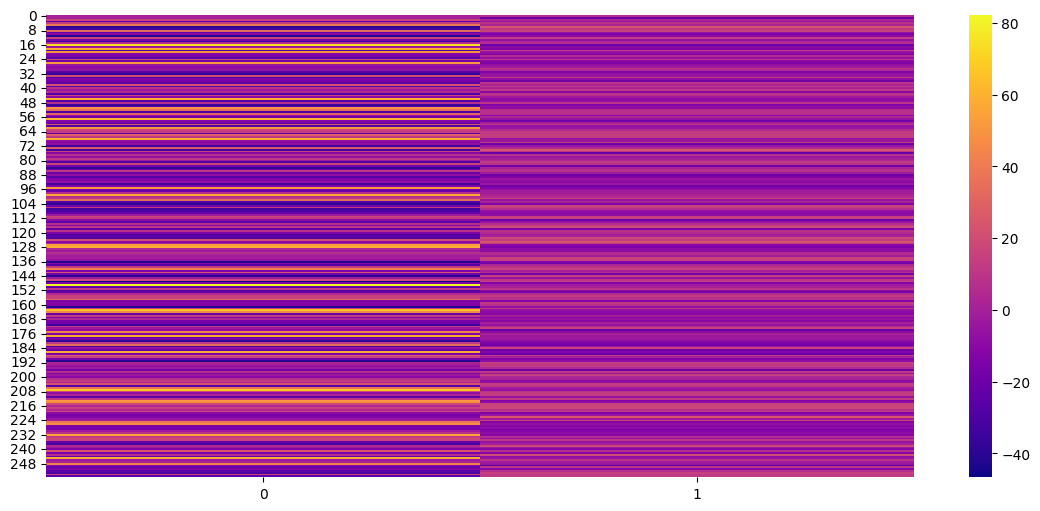

In [30]:
# plot heatmap using sns.heatmap()
import seaborn as sns

# plot heatmap using sns.heatmap()
plt.figure(figsize=(14, 6))
sns.heatmap(transformed_x, cmap='plasma')


### PCA with 3 Components

In [29]:
pca = PCA(n_components=3)
transformed_x = pca.fit_transform(train_data_scaled)

#### Plot the 3d pca

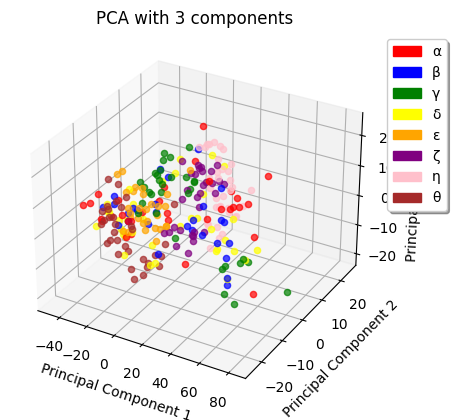

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create empty lists to store legend handles and labels
legend_handles = []
legend_labels = []

# Iterate through the transformed data, organized by group
for i, x in enumerate(transformed_x):
    label = labels[y_train[i]]
    color = colors[y_train[i]]
    ax.scatter(x[0], x[1],x[2], alpha=0.7, label=label, color=color)

    # Append a patch with custom color to the legend_handles list
    if label not in legend_labels:
        legend_patch = mpatches.Patch(color=color, label=label)
        legend_handles.append(legend_patch)
        legend_labels.append(label)

# Sort the legend labels alphabetically
sorted_legend_labels = sorted(legend_labels)

# Create a new list of sorted legend handles corresponding to the sorted labels
sorted_legend_handles = [legend_handles[legend_labels.index(label)] for label in sorted_legend_labels]

# Add the custom legend using the created handles and labels
ax.legend(handles=sorted_legend_handles, labels=sorted_legend_labels, loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1, fancybox=True, shadow=True)

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("PCA with 3 components")
ax.xaxis.grid(True)
plt.show()

### PCA with X% of the variance of the dataset, for training the statistical AI Models

In [31]:
# pca with x% variance
pca = PCA(0.98)
X_train = pca.fit_transform(train_data_scaled)
X_test = pca.transform(test_data_scaled)

## Classifier - Statistical Learning

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

## Svm

#### Apply classifier

In [33]:
from sklearn.svm import SVC

In [34]:
svm = SVC(kernel="linear", C=1, random_state= config["random_state"])
svm.fit(X_train, y_train)

SVC(C=1, kernel='linear', random_state=42)

#### Evaluate classifier

Accuracy:  0.828125
              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       1.00      0.75      0.86        12
           2       0.80      1.00      0.89         8
           3       0.57      1.00      0.73         4
           4       1.00      0.91      0.95        11
           5       0.89      0.89      0.89         9
           6       0.83      1.00      0.91         5
           7       0.80      0.57      0.67         7

    accuracy                           0.83        64
   macro avg       0.81      0.84      0.81        64
weighted avg       0.85      0.83      0.83        64



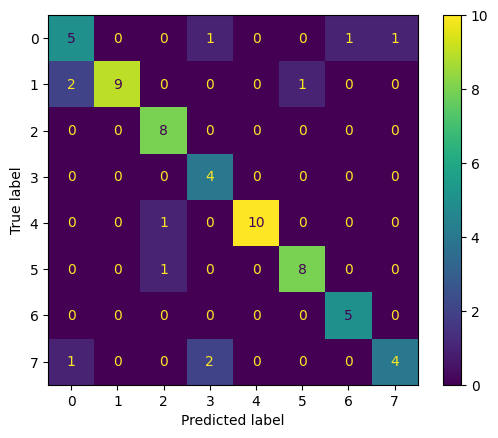

In [35]:
accuracy = svm.score(X_test, y_test)
print("Accuracy: ", accuracy)

# classification report
print(classification_report(y_test, svm.predict(X_test)))

# confusion matrix
cm = confusion_matrix(y_test, svm.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

#### Apply optimization with Grid Search and Cross-validation

In [36]:
from sklearn.model_selection import GridSearchCV

# Apply grid search to find best parameters for SVM
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf', 'poly']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=0, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf', 'poly']})

#### Evaluate optimized classifier

Best parameters:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best estimator:  SVC(C=10, gamma=0.001)
Best score:  0.8552036199095022
Accuracy:  0.828125


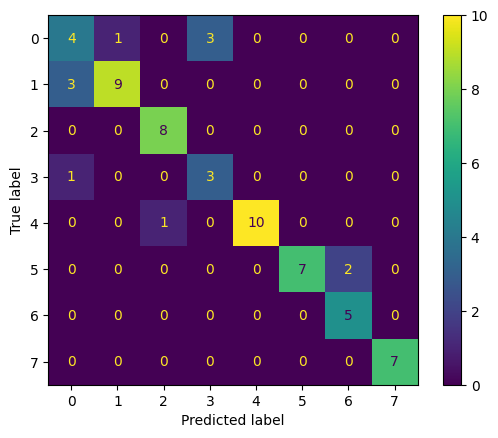

In [37]:
# evaluate the model
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

# Evaluate the model on the test data using `score`
y_pred = grid.predict(X_test)
accuracy = grid.score(X_test, y_test)
print("Accuracy: ", accuracy)

# confusion matrix for the best model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()
plt.show()

## Random Forest

#### Apply classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rf = RandomForestClassifier(n_estimators=100, random_state=config["random_state"], verbose=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluate classifier

Accuracy:  0.84375
              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       1.00      0.75      0.86        12
           2       0.80      1.00      0.89         8
           3       0.57      1.00      0.73         4
           4       1.00      0.91      0.95        11
           5       0.89      0.89      0.89         9
           6       0.83      1.00      0.91         5
           7       0.80      0.57      0.67         7

    accuracy                           0.83        64
   macro avg       0.81      0.84      0.81        64
weighted avg       0.85      0.83      0.83        64



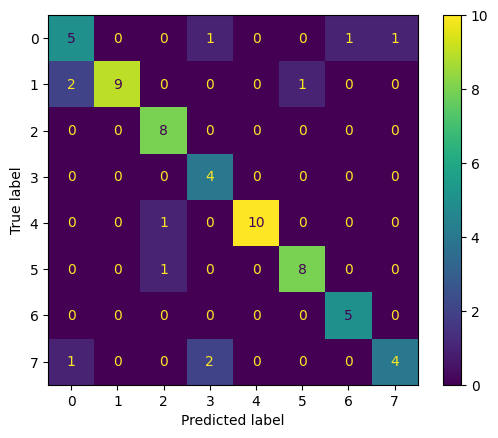

In [40]:
accuracy = rf.score(X_test, y_test)
print("Accuracy: ", accuracy)

print(classification_report(y_test, svm.predict(X_test)))

# confusion matrix
cm = confusion_matrix(y_test, svm.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()


#### Apply optimization with Grid Search and Cross-validation

In [41]:
# Apply grid search to find best parameters for Random Forest
param_grid = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [10, 20, 30, 40, 50]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=0, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'n_estimators': [100, 200, 300, 400, 500]})

### Evaluate optimized classifier

Best parameters:  {'max_depth': 20, 'n_estimators': 500}
Best estimator:  RandomForestClassifier(max_depth=20, n_estimators=500)
Best score:  0.8240573152337859
Accuracy:  0.859375
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.90      0.75      0.82        12
           2       0.88      0.88      0.88         8
           3       0.67      1.00      0.80         4
           4       0.83      0.91      0.87        11
           5       1.00      0.89      0.94         9
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         7

    accuracy                           0.86        64
   macro avg       0.85      0.88      0.86        64
weighted avg       0.87      0.86      0.86        64



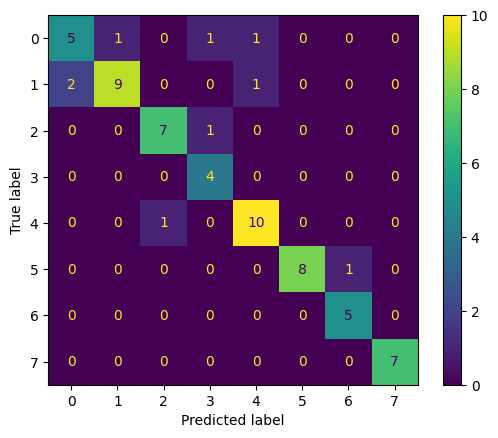

In [42]:
# evaluate the model
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)
print("Accuracy: ", grid.score(X_test, y_test))

# classification report
print(classification_report(y_test, grid.predict(X_test)))

# confusion matrix for the best model
cm = confusion_matrix(y_test, grid.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot()



## Classifier - Neural Network

In [43]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten

In [44]:
from utils import impute_nan
X2 = impute_nan(X)

#### Split the data into training, testing, and validation sets

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

#### Number of classes to predict

In [46]:
y_np_array = np.array(y)
n_outputs = len(np.unique(y_np_array))
print("Number of outputs (classes) the model to predict:", n_outputs)

Number of outputs (classes) the model to predict: 8


#### Encode y data (one hot encoding)

In [47]:
from sklearn.preprocessing import OneHotEncoder
# encode labels with one hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

### Create the Neural Network (NN) Architecture and instantiate the model

In [48]:
model = Sequential()
model.add(Dense(60, activation="relu", input_shape=X[0].shape))
model.add(Dense(n_outputs, activation="softmax"))

Plot the summary of the TensorFlow model

In [49]:
# plot the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8, 60)             10860     
                                                                 
 dense_1 (Dense)             (None, 8, 8)              488       
                                                                 
Total params: 11,348
Trainable params: 11,348
Non-trainable params: 0
_________________________________________________________________


### Build the NN model

In [50]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy", "sparse_categorical_crossentropy", "sparse_categorical_accuracy"])

### Train the NN model

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

In [52]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config["random_state"])

In [53]:
# Initialize the lists to store the accuracy scores
acc_scores = []
sce_scores = []
sca_scores = []
train_losses = []
train_accs = []
val_losses = []
val_accs = []

In [54]:
for train_index, test_index in skf.split(X2, y):
    X_train, X_test = X2[train_index], X2[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state= config["random_state"])

    # convert labels to one hot encoding
    enc = OneHotEncoder(handle_unknown='ignore')
    y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
    y_val = enc.transform(y_val.reshape(-1, 1)).toarray()
    y_test = enc.transform(y_test.reshape(-1, 1)).toarray()

    # fit the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=0, workers=4, use_multiprocessing=True)

    # Track the training and validation loss and accuracy
    train_losses.append(history.history['loss'])
    train_accs.append(history.history['accuracy'])
    val_losses.append(history.history['val_loss'])
    val_accs.append(history.history['val_accuracy'])

    # evaluate the model on the test data using `evaluate`
    scores = model.evaluate(X_test, y_test, verbose=0)
    acc_scores.append(scores[1] * 100)
    sce_scores.append(scores[2])
    sca_scores.append(scores[3])

In [55]:
# Calculate the average accuracy and loss over all of the folds
acc_mean = np.mean(acc_scores)
sce_mean = np.mean(sce_scores)
sca_mean = np.mean(sca_scores)
train_loss_mean = np.mean(train_losses, axis=0)
train_acc_mean = np.mean(train_accs, axis=0)
val_loss_mean = np.mean(val_losses, axis=0)
val_acc_mean = np.mean(val_accs, axis=0)

In [56]:
# print the results
print("Accuracy: %.2f%% (+/- %.2f%%)" % (acc_mean, np.std(acc_scores)))
print("Sparse Categorical Cross Entropy: %.2f%% (+/- %.2f%%)" % (sce_mean, np.std(sce_scores)))
print("Sparse Categorical Accuracy: %.2f%% (+/- %.2f%%)" % (sca_mean, np.std(sca_scores)))

Accuracy: 87.66% (+/- 0.52%)
Sparse Categorical Cross Entropy: 0.35% (+/- 0.02%)
Sparse Categorical Accuracy: 0.88% (+/- 0.01%)


In [57]:
# Train the model and validate it with the validation set
print(X_train.shape, y_train.shape)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=0)

(204, 8, 180) (204, 8)


### Evaluate the model on the test data

In [58]:
# Evaluate the model on the test data using `evaluate`
results = model.evaluate(X_test, y_test, batch_size=32)

print("Training History:")
print(history.history)

print("\nEvaluation Results:")
print("Loss:", results[0])
print("Accuracy:", results[1])

2/2 [==============================] - 0s 7ms/step - loss: 0.3758 - accuracy: 0.8750 - sparse_categorical_crossentropy: 0.3758 - sparse_categorical_accuracy: 0.8750
Training History:
{'loss': [0.28263330459594727, 0.2828841507434845, 0.28430747985839844, 0.28481531143188477, 0.28379738330841064, 0.2828209698200226, 0.282179594039917, 0.28247979283332825, 0.2826409935951233, 0.2818831503391266, 0.28298085927963257, 0.282558411359787, 0.2812393307685852, 0.2816772162914276, 0.2822624742984772, 0.2810772955417633, 0.2822026014328003, 0.2817333936691284, 0.28450530767440796, 0.2810610830783844, 0.2818548083305359, 0.2811841666698456, 0.2811819314956665, 0.28026071190834045, 0.2801661491394043, 0.28185129165649414, 0.2815404236316681, 0.2826415002346039, 0.2803924083709717, 0.27974405884742737, 0.27979254722595215, 0.2798280417919159, 0.2788165211677551, 0.27961304783821106, 0.2807275056838989, 0.27941471338272095, 0.28118613362312317, 0.2812630236148834, 0.280627965927124, 0.27812063694000

### Plot and interpret the learning curves: Loss and Accuracy based on the training and validation sets

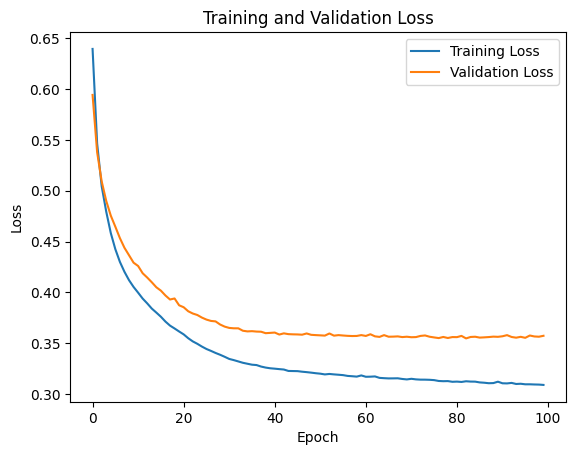

In [61]:
plt.plot(np.mean(train_losses, axis=0), label="Training Loss")
plt.plot(np.mean(val_losses, axis=0), label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

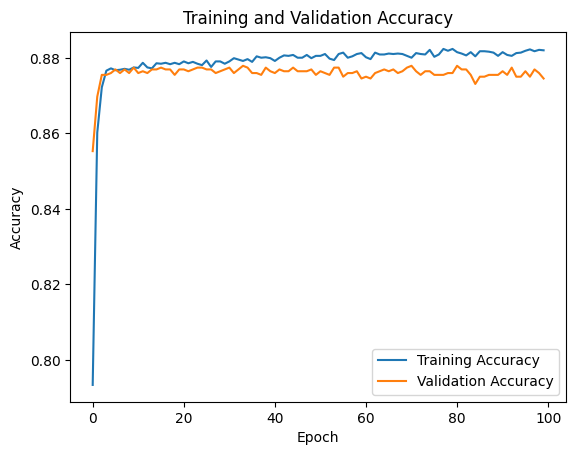

In [62]:
plt.plot(np.mean(train_accs, axis=0), label="Training Accuracy")
plt.plot(np.mean(val_accs, axis=0), label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()